##This is a stacked autoencoder



In [1]:
# this is just to suppress some anoying warning messages
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py

import sys
import numpy as np

import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.callbacks import Callback, EarlyStopping
import keras as K

from keras.datasets import mnist

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import time

# needed in Google Colaboratory for callback plots:
from IPython.display import clear_output
# needed in notebooks for plotting:
%matplotlib inline

from skimage.measure import compare_mse
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
# callback class for training visualisation and console print
class LogCallback(Callback):
    def __init__(self):

      def on_train_begin(self, logs= None):
          self.start_time = time.time()
          self.fig = plt.figure(figsize=(5,4))
          self.ax1 = self.fig.add_subplot(111)
          self.ax1.set_xlabel('Iteration')
          self.ax1.set_ylabel('Loss')
          self.ax1.set_title('Loss Curve')
          self.ax1.grid()

          custom_lines = [Line2D([0], [0], color='r', lw=1),
                          Line2D([0], [0], color='g', lw=1)]

          self.ax1.legend(custom_lines, ['Training', 'Test'])

          plt.tight_layout()
          self.train_losses = []
          self.test_losses = []
          self.train_acc = []
          self.test_acc = []
          self.min_test_loss= np.Inf
          self.no_improve_cnt= 0

      def on_epoch_begin(self, epoch, logs= None):
          self.start_time_epoche = time.time()

      def on_epoch_end(self, epoch, logs=None):
          self.elapsed_epoch_time= time.time()-self.start_time_epoche
          self.train_losses.append(logs.get('loss'))
          self.test_losses.append(logs.get('val_loss'))
          self.train_acc.append(logs.get('acc'))
          self.test_acc.append(logs.get('val_acc'))

          clear_output(wait=True)

          self.ax1.plot(self.train_losses, linewidth=.5, color='r')
          self.ax1.plot(self.test_losses, linewidth=.5, color='g')
          self.ax1.set_ylim([0, max([self.train_losses, self.test_losses])[0]])

          plt.draw()
          plt.show()
          #plt.pause(0.0001)

          print('Epoche %i/%i: train loss: %.4f - test loss: %.4f  [time: %.4f sec.]' %
               (len(self.train_losses), max_epoches, self.train_losses[-1], self.test_losses[-1],
                self.elapsed_epoch_time))

          if (len(self.test_losses) > 1) and (self.test_losses[-1] < (self.min_test_loss - delta)):
              self.min_test_loss= self.test_losses[-1]
              self.no_improve_cnt= 0
          else:
              self.no_improve_cnt += 1

          if self.no_improve_cnt == patience:
             print('\nNo improvement for %i epoches. Performing early stopping.' % patience)

      def on_train_end(self, logs= None):
          print('\nTotal training time: %.2f sec.' % (time.time()-self.start_time))

In [0]:
class LogCallback(Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []
    self.acc = []
    self.val_acc = []
    self.fig = plt.figure()
    self.logs = []
    self.start_time = time.time()
    self.no_improve_cnt= 0
    self.min_test_loss= np.Inf

  def on_epoch_end(self, epoch, logs={None}):
    self.logs.append(logs)
    self.x.append(self.i)
    self.i += 1
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.acc.append(logs.get('acc'))
    self.val_acc.append(logs.get('val_acc'))

    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    clear_output(wait=True)

    ax1.plot(self.x, self.losses, label="loss")
    ax1.plot(self.x, self.val_losses, label="validation loss")
    ax1.legend()

    ax2.plot(self.x, self.acc, label="accuracy")
    ax2.plot(self.x, self.val_acc, label="validation accuracy")
    ax2.legend()

    plt.show()

  def on_train_end(self, logs=None):
    print(f'Total training time: {time.time()-self.start_time:.2f} sec.')

In [0]:
# a function for plotting a specified number of images: original vs. encoded vs. decoded
def plot_encoded_img(imgs, encoded_img, rnd_idx, aspect_ratio=0.1, decoded_img= None, title= None):
    plt.figure(figsize=(18, 8))
    if title is not None:
        plt.suptitle(title, fontsize= 16)

    for i, image_idx in enumerate(rnd_idx):
        # plot original image
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(imgs[image_idx].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # plot encoded image
        ax = plt.subplot(3, num_images, num_images + i + 1)
        # plt.imshow(encoded_imgs[image_idx].reshape(8, 4))

        plt.imshow(encoded_img[image_idx].reshape(-1, 1), aspect=aspect_ratio)
        # print(tabulate(encoded_imgs[image_idx].reshape(1,-1), tablefmt= 'plain', floatfmt=".4f"))

        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if decoded_img is not None:
            # plot reconstructed image
            ax = plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(decoded_img[image_idx].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
  #plt.show()

In [6]:
print('NumPy Version: %s' % np.__version__)
print('Tensorflow Version: %s' % tf.__version__)
print('Keras Version: %s\n' % K.__version__)

NumPy Version: 1.14.6
Tensorflow Version: 1.12.0
Keras Version: 2.2.4



In [0]:
# definition of early stopping object here
patience= 5
early_stop = EarlyStopping(monitor='val_loss', min_delta=1e-04, patience=patience, mode='auto')

max_epoches= 25
delta= 1e-4
batch_size=128
DoTraining= 1

In [8]:
# load the mnist image data (28x28px)
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [0]:
# for selection of just a subset (faster computation to check if everything runs ok)
# X_train= X_train[0:1000,:]
# X_test= X_test[0:200,:]
#
# Y_train= Y_train[0:1000]
# y_test= y_test[0:200]

In [9]:
# normalize images within the interval [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# flatten the 28x28 images into a 1d vector (784,1)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [0]:
# get dimensions for the AE's input layer
input_dim = x_train.shape[1]

# TODO: define size of encoded representations for the 2 stacks
encoding_dim1 = 128
encoding_dim2 = 32

In [11]:
# TODO: compute compression factor, i.e. dimensionality reduction
compression_factor = input_dim / encoding_dim1
print('Compression factor: %.1f' % compression_factor)

Compression factor: 6.1


In [0]:
# TODO: define autoencoder stack 1
autoencoder1= Sequential()
autoencoder1.add(Dense(encoding_dim1, input_dim=input_dim, activation="sigmoid"))
autoencoder1.add(Dense(input_dim, input_dim=encoding_dim1, activation="sigmoid"))

In [0]:
# TODO: define autoencoder stack 2
autoencoder2= Sequential()
autoencoder2.add(Dense(encoding_dim2, input_dim=encoding_dim1, activation="sigmoid"))
autoencoder2.add(Dense(encoding_dim1, input_dim=encoding_dim2, activation="sigmoid"))

In [14]:
# print the architectures of the two stacks of the autoencoder
print(autoencoder1.summary())
print(autoencoder2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
Total params: 8,352
Trainable params: 8,352
Non-trainable params: 0
_________________________________________________________________
None


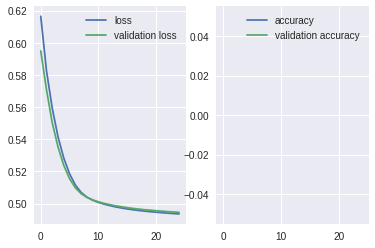

Total training time: 29.77 sec.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                4128      
Total params: 4,128
Trainable params: 4,128
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingStack1 (Dense)       (None, 128)               100480    
_________________________________________________________________
EncodingStack2 (Dense)       (None, 32)                4128      
_________________________________________________________________
DecodingStack2 (Dense)       (None, 128)               4224      
_________________________________________________________________
DecodingStack1 (Dense)       (None, 784)               101136    
Total params: 209,968
Trainable param

In [15]:
if DoTraining == 1:

    #+++++++++++++++ STACK 1
    # initialize 1st logging callback
    live_hist1 = LogCallback()
    # binary_crossentropy usually is the better loss metric, but is about a factor two per epoche slower
    autoencoder1.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder1.fit(x_train, x_train, epochs=max_epoches, batch_size=batch_size, shuffle=True, validation_split=0.3,
                     verbose=0, callbacks=[live_hist1])

    # extract the encoder section of the first autoencoder stack to visualize the encoded representation. Also needed
    # to provide the encoded input for the second autoencoder stack.
    encoder_stack1 = autoencoder1.layers[0]
    encoder1 = Sequential()
    encoder1.add(encoder_stack1)
    print(encoder1.summary())

    # encode training images with first autoencoder stack. They'll serve as input for the autoencoder stack 2
    encoded1_imgs = encoder1.predict(x_train)

    # here you could use the plot_encoded_img function to check if the autoencoder works properly and training was
    # successful

    # +++++++++++++++ STACK 2
    # initialize 2nd logging callback
    live_hist2 = LogCallback()
    # binary_crossentropy usually is the better loss metric, but is about a factor two per epoche slower
    autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder2.fit(encoded1_imgs, encoded1_imgs, epochs=max_epoches, batch_size=batch_size, shuffle=True, validation_split=0.3,
                     verbose=0, callbacks=[live_hist1])

    # extract just the second encoder to visualize the latent space (its just needed to get weights and bias
    # before stacking together the entire autoencoder. Also might be useful for testing and visualisation of
    # the latent space
    encoder_stack2 = autoencoder2.layers[0]
    encoder2 = Sequential()
    encoder2.add(encoder_stack2)
    print(encoder2.summary())
    # to check the encoded image in latent space, encode the images encoded by autoencoder stack 1, with autoencoder
    # stack 2 and display them using plot_encoded_img
    encoded2_imgs = encoder2.predict(encoded1_imgs)


    # TODO: put together the entire stacked autoencoder
    # TODO: first get weights and bias for the encoder and decoder layers of both stacks (get_weights() returns weights
    # TODO: and bias in a list)
    enc1_weights= encoder_stack1.get_weights()
    enc2_weights= encoder_stack2.get_weights()

    # TODO: extract the decoder layer and get weights and bias (for both stacks)
    decoder_stack1= autoencoder1.layers[1]
    dec1_weights = decoder_stack1.get_weights()
    decoder_stack2 = autoencoder2.layers[1]
    dec2_weights = decoder_stack2.get_weights()


    # build the full stacked autoencoder's architecture (input layer is derived implicitly from input_dim)
    # build the stacked autoencoder (input layer is derived implicitly from input_dim)
    stacked_autoencoder = Sequential()
    stacked_autoencoder.add(Dense(encoding_dim1, input_shape=(input_dim,), activation='sigmoid', name='EncodingStack1'))
    stacked_autoencoder.add(Dense(encoding_dim2, activation='sigmoid', name='EncodingStack2'))
    stacked_autoencoder.add(Dense(encoding_dim1, activation='sigmoid', name='DecodingStack2'))
    stacked_autoencoder.add(Dense(input_dim, activation='sigmoid', name='DecodingStack1'))

    stacked_autoencoder.compile(optimizer='adam', loss='mse')

    # TODO: set weights accordingly
    stacked_autoencoder.layers[0].set_weights(enc1_weights)
    stacked_autoencoder.layers[1].set_weights(enc2_weights)
    stacked_autoencoder.layers[2].set_weights(dec2_weights)
    stacked_autoencoder.layers[3].set_weights(dec1_weights)

    print(stacked_autoencoder.summary())

    # now you could use stacked_autoencoder.predict(x_test) and the plot_encoded_img function to check if the stacked
    # autoencoder trained successfully and all weights have been set correctly (this is later in the code done anyway,
    # but with the model loaded from the
    # saved .h5-files


    # TODO: build just the encoder section which serves e.g. as a feature extractor or dimensionality reducer
    stacked_encoder = Sequential()
    stacked_encoder.add(encoder_stack1) # encoder stack 1
    stacked_encoder.add(encoder_stack2) # encoder stack 2
    stacked_encoder.compile(optimizer='adam', loss='mse')

    # TODO: set the weights of each encoder stack
    stacked_encoder.layers[0].set_weights(enc1_weights)
    stacked_encoder.layers[1].set_weights(enc2_weights)
    print(stacked_encoder.summary())

    # save the entire model graph with weights
    stacked_autoencoder.save('stacked_autoencoder.h5')
    stacked_encoder.save('stacked_encoder.h5')

In [0]:
#load the entire model (no compilation necessary)
stacked_autoencoder= load_model('stacked_autoencoder.h5')
stacked_encoder= load_model('stacked_encoder.h5')

In [17]:
# encode the original image using just the encoder sectioni
encoded_imgs = stacked_encoder.predict(x_test)
# encode/decode the original image using a full autoencoder stack
decoded_imgs = stacked_autoencoder.predict(x_test)
encoded_imgs.shape

(10000, 32)

In [18]:
# compute the average MSE over all test images (original/decoded)

mse = np.empty(len(decoded_imgs))

for i in range(0,len(decoded_imgs)):
    mse[i] = compare_mse(decoded_imgs[i], x_test[i])
    
avg_mse = sum(mse)/len(mse)
print('Average MSE for all original/decoded images: %.4f' % avg_mse)

Average MSE for all original/decoded images: 0.0172


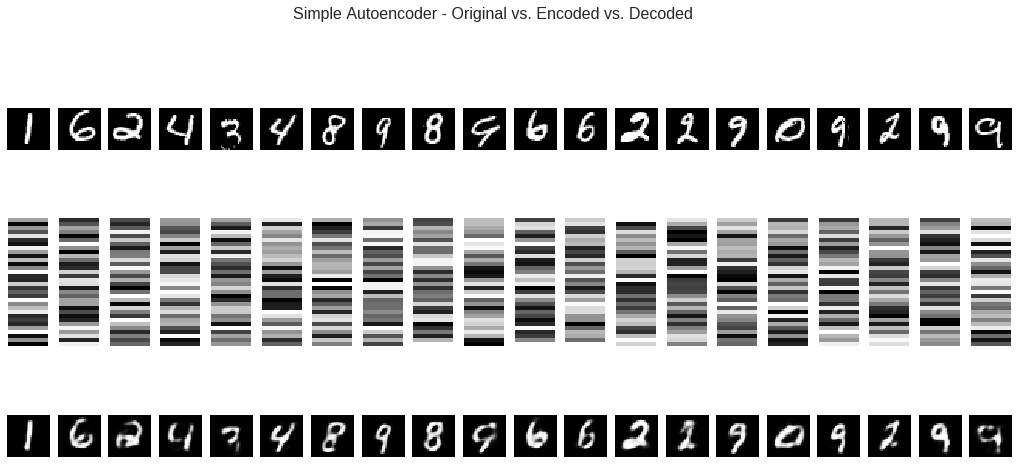

In [19]:
# plots a random selection of images: original vs. encoded vs. decoded
# a random index is generated in order to select original/encoded/decoded images from
# the test set
num_images = 20
np.random.seed(42)
random_img_idx = np.random.randint(x_test.shape[0], size=num_images)
plot_encoded_img(x_test, encoded_imgs, random_img_idx, aspect_ratio=0.1, decoded_img= decoded_imgs, title='Simple Autoencoder - Original vs. Encoded vs. Decoded')
plt.show()